In [394]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten
from keras import utils as np_utils
from keras.models import load_model
import os
from pathlib import Path

<h3>1. Data extraction</h3>


In [395]:
label_names = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
data_train_path = Path('./OCRStandard/archive/data/training_data')
data_test_path = Path('./OCRStandard/archive/data/testing_data')

In [396]:
# Generate dataframe from data images
def generate_dataframe(data_path):
    data_list = []
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            data = {}
            data['filename'] = str(os.path.join(subdir,file))
            data['label'] = str(os.path.basename(subdir))
            data_list.append(data)  

    df = pd.DataFrame(data_list) 
    return df

Train data

In [397]:
df_train = generate_dataframe(data_train_path)

In [398]:
print(df_train.shape)
df_train.head()

(20628, 2)


,filename,label
0,OCRStandard/archive/data/training_data/0/0.png,0
1,OCRStandard/archive/data/training_data/0/10008...,0
2,OCRStandard/archive/data/training_data/0/10044...,0
3,OCRStandard/archive/data/training_data/0/1008.png,0
4,OCRStandard/archive/data/training_data/0/10080...,0


Test Data

In [399]:
df_test = generate_dataframe(data_test_path)

In [400]:
print(df_test.shape)
df_test.head()

(1008, 2)


,filename,label
0,OCRStandard/archive/data/testing_data/0/28310.png,0
1,OCRStandard/archive/data/testing_data/0/28346.png,0
2,OCRStandard/archive/data/testing_data/0/28382.png,0
3,OCRStandard/archive/data/testing_data/0/28418.png,0
4,OCRStandard/archive/data/testing_data/0/28454.png,0


##### Shuffle data

In [401]:
df_train = np.array(df_train)
np.random.shuffle(df_train)
df_train = pd.DataFrame(df_train) 

In [402]:
df_train = df_train.rename(columns={0: 'filename', 1: 'label'})

In [403]:
df_train.head()

,filename,label
0,OCRStandard/archive/data/training_data/Q/3266.png,Q
1,OCRStandard/archive/data/training_data/T/12881...,T
2,OCRStandard/archive/data/training_data/1/20413...,1
3,OCRStandard/archive/data/training_data/K/10928...,K
4,OCRStandard/archive/data/training_data/W/20264...,W


##### Read image data

In [404]:
def plot_sample(df):
    plt.figure(figsize=(10,10))
    for i in range(25): # 25 images
        plt.subplot(5,5,i+1) # matrix of 5 X 5 array
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        im = cv2.imread(str(df_train.values[int(i*800)][0]))
        plt.imshow(im, cmap=plt.cm.binary) 
        plt.xlabel("%s" % (df_train.values[int(i*800)][1])) 

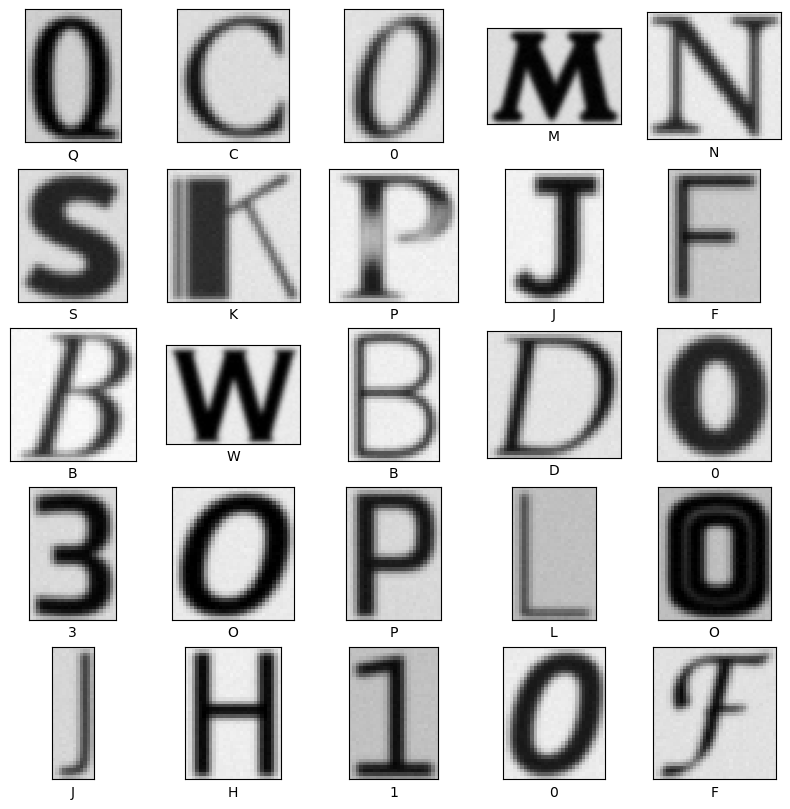

In [405]:
plot_sample(df_train)

##### Resize Image 

In [409]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_RGB2GRAY)

Generate labels dictionary

In [413]:
def generate_label_dict(label_names):
    labels_dict = {}
    for i in range(len(label_names)):
        labels_dict[i] = label_names[i]
    return labels_dict

In [414]:
labels_dict = generate_label_dict(label_names)

##### Convert labels to integer

In [415]:
def convert_label_int(label):
    label_int = 0
    for i in range(len(label_names)):
        if label == label_names[i]:
            label_int = i
            break
    return label_int

##### Load and split data

In [416]:
def resize_image(im):
    return cv2.resize(im, (32,38))

In [417]:
# Load X_train, y_train from df_train

def load_train_data(df_train):
    X_train, y_train = [], []
    for index, row in df_train.iterrows():
        im = read_image(row['filename'])
        im = resize_image(im)
        label = row['label']
        # convert to numpy array
        im = im / 255
        im = np.array(im)
        im = np.expand_dims(im, axis=2)

        X_train.append(im)
        y_train.append(convert_label_int(label))
    return (X_train, y_train)

def load_test_data(df_test):
    X_test, y_test = [], []
    for index, row in df_test.iterrows():
        im = read_image(row['filename'])
        im = resize_image(im)
        im = im / 255
        label = row['label']
        # convert to numpy array
        im = np.array(im)
        im = np.expand_dims(im, axis=2)
        
        X_test.append(im)
        y_test.append(convert_label_int(label))
    return (X_test, y_test)

In [418]:
X_train, y_train = load_train_data(df_train)


In [419]:
X_test, y_test = load_test_data(df_test)

In [420]:
# Convert to numpy array for training
X_train = np.array(X_train)
X_test = np.array(X_test)

In [421]:

# One hot encode Y 
n_classes = len(label_names) # number of classes to classify
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [422]:
print(Y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [423]:
print(X_train.shape)
print(Y_train.shape)

(20628, 38, 32, 1)
(20628, 36)


##### Visualize train data

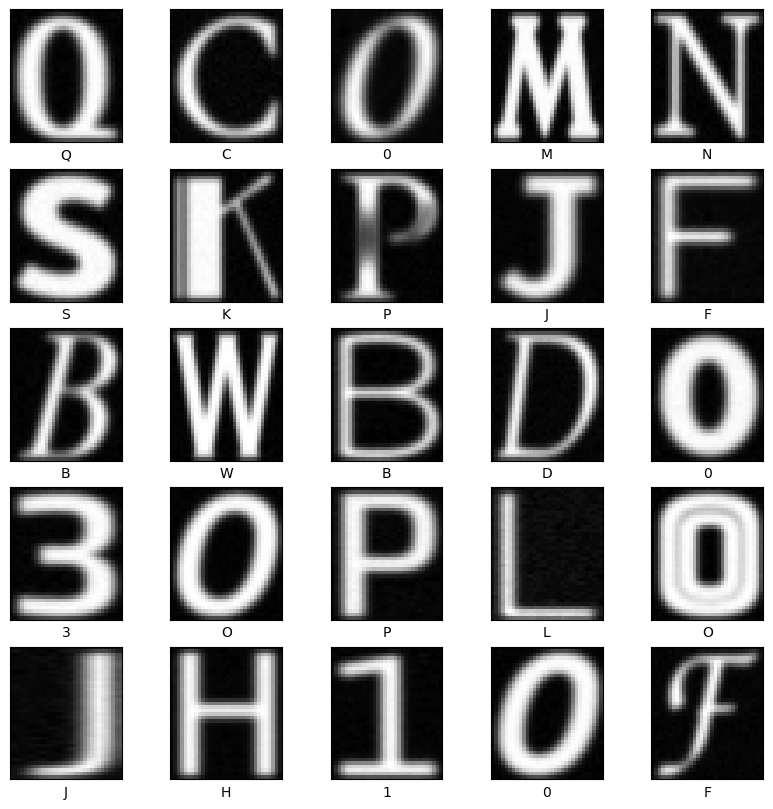

In [424]:
plt.figure(figsize=(10,10))
for i in range(25): # 25 images
  plt.subplot(5,5,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i*800], cmap=plt.cm.binary) # printing binary/black and white image
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
  plt.xlabel("%s" % labels_dict[y_train[i*800]])# Assigning name to each image
plt.show()

In [425]:
X_train[800].shape

(38, 32, 1)

##### Validate training data

In [426]:
len(X_train)

20628

### 2. CNN 

Train

In [538]:
# Build model
model = Sequential()
# Convolution 
model.add(Conv2D(6, kernel_size=(3,3), padding='same', activation='tanh', input_shape=(38, 32, 1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='tanh'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(36, activation='softmax'))

In [539]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 38, 32, 6)         60        
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 19, 16, 6)         0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 19, 16, 6)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 19, 16, 16)        880       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 9, 8, 16)          0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 9, 8, 16)        

In [540]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


model.fit(  X_train, Y_train, 
            batch_size=128, 
            epochs=30, 
            validation_data=(X_test, Y_test), 
        )

model.save("./OCRModel/model.h5")

Epoch 1/30


162/162 [==============================] - 11s 56ms/step - loss: 1.2533 - accuracy: 0.7079 - val_loss: 0.2196 - val_accuracy: 0.9484
Epoch 2/30
162/162 [==============================] - 9s 56ms/step - loss: 0.3383 - accuracy: 0.9166 - val_loss: 0.1058 - val_accuracy: 0.9732
Epoch 3/30
162/162 [==============================] - 9s 56ms/step - loss: 0.2560 - accuracy: 0.9311 - val_loss: 0.0956 - val_accuracy: 0.9702
Epoch 4/30
162/162 [==============================] - 9s 58ms/step - loss: 0.2144 - accuracy: 0.9409 - val_loss: 0.0679 - val_accuracy: 0.9772
Epoch 5/30
162/162 [==============================] - 9s 57ms/step - loss: 0.1913 - accuracy: 0.9449 - val_loss: 0.0600 - val_accuracy: 0.9812
Epoch 6/30
162/162 [==============================] - 9s 56ms/step - loss: 0.1748 - accuracy: 0.9491 - val_loss: 0.0548 - val_accuracy: 0.9831
Epoch 7/30
162/162 [==============================] - 8s 51ms/step - loss: 0.1589 - accuracy: 0.9516 - val_loss: 0.0494 - val_accuracy: 0.9861
Epoch 8/3

Test accuracy

In [541]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("accuracy:", test_acc)

32/32 [==============================] - 0s 8ms/step - loss: 0.0303 - accuracy: 0.9861
accuracy: 0.9861111044883728


In [542]:
predictions=model.predict(X_test)

# Prediction of the 1st result. It will show the 10 predictions of labels for test image
print("1. Prediction array: %s" % (predictions[0]))

# we will verify that which result for label has highest confidence
print("2. Label number having highest confidence in prediction array: %s" % (np.argmax(predictions[0])))

# let us verify what is the label in test_labels.
print("3. Actual label in dataset: %s" % (Y_test[0]))

32/32 [==============================] - 0s 5ms/step
1. Prediction array: [8.65036428e-01 1.90543801e-06 3.74949707e-07 3.42685369e-09
 8.27375152e-06 1.28195268e-07 1.98492216e-06 1.14239633e-07
 4.46056241e-08 8.78045103e-06 1.48252786e-06 3.55735096e-07
 3.67079519e-05 1.94220818e-04 1.03443987e-09 6.49054721e-09
 5.57879412e-06 1.78040818e-08 2.08185284e-05 7.57555085e-07
 6.86940921e-11 2.28550068e-08 5.41706981e-07 3.33589924e-07
 1.33446887e-01 7.58922124e-06 1.13856629e-03 3.98923561e-08
 1.34324871e-08 5.95325048e-07 7.34248970e-05 1.27174235e-05
 1.37315556e-06 1.07665537e-12 3.62169561e-09 2.99620800e-10]
2. Label number having highest confidence in prediction array: 0
3. Actual label in dataset: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Predict on test set

In [543]:
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array
  
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary) # showing b/w image

  # Get index with the largest softmax output
  predicted_label=np.argmax(predictions_array)

  true_label=np.argmax(true_label)

  # print(predicted_label)
  # print(true_label)
  
  if predicted_label == true_label: #setting up label color
    color='blue' # correct then blue colour
    
  else:
    color='red' # wrong then red colour

  # Assign class name with the corresponding index from the argmax function
  plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                       100*np.max(predictions_array),
                                       label_names[true_label]),
             color=color)
  
# function to display bar chart showing whether image prediction is how much correct  


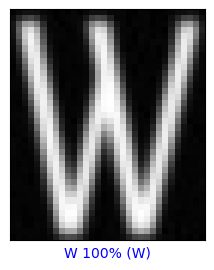

In [544]:
# defining parameters to pass to function
i=900 # image number 56. You may change value of i for play around
plt.figure(figsize=(6,3))
plot_image(i, predictions, Y_test, X_test)
plt.show()

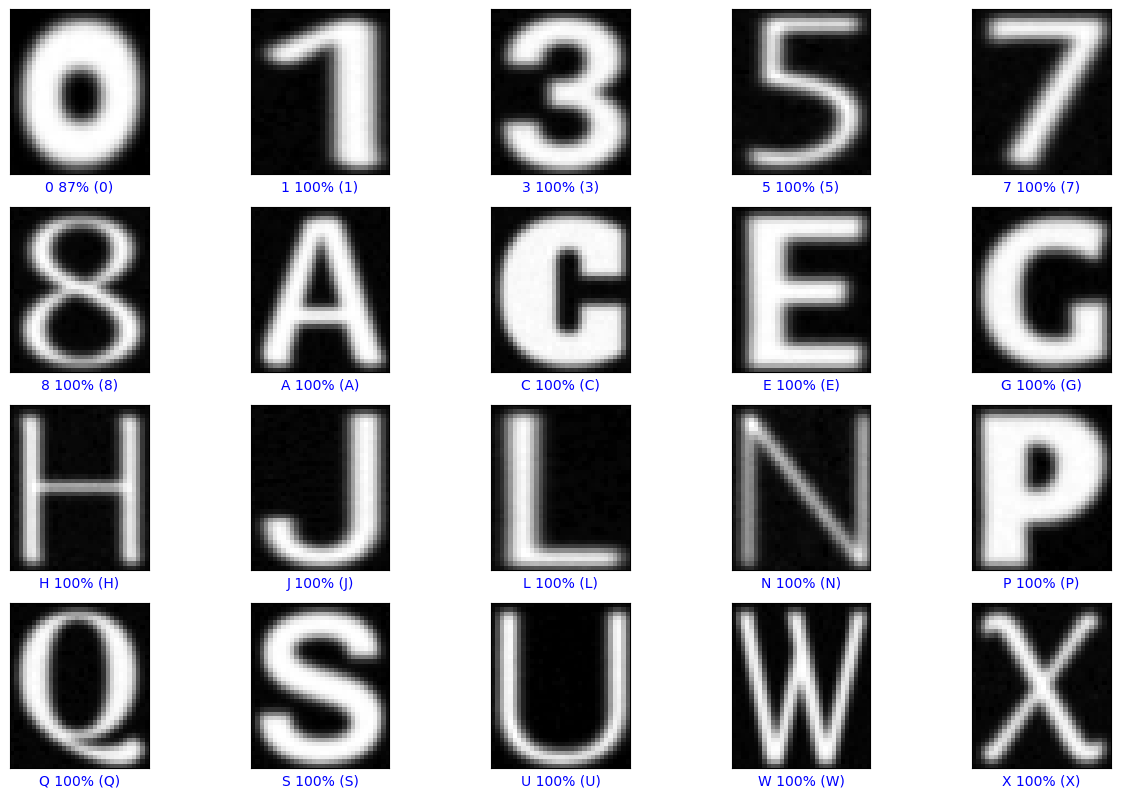

In [545]:
# verification of several images
num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(15,15))
for i in range(20):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(int(i*50),predictions, Y_test, X_test)
plt.show()

##### 3. Predict

Load model

In [546]:
# load model
saved_model = load_model('./OCRModel/model.h5')
saved_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 38, 32, 6)         60        
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 19, 16, 6)         0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 19, 16, 6)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 19, 16, 16)        880       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 9, 8, 16)          0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 9, 8, 16)        

Image preprocessing

In [547]:
# Word segmentation
def text_line_cut(image):
    # reading image
    (_, bin_img) = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

    text_lines = [[]]
    flag = True
    lines = 0

    for i in range(0, bin_img.shape[0]):
        # if number of white phixels in row is greater than 750
        if (bin_img[i].sum() >= 255*(len(bin_img[i]))):
            flag = False
            if len(text_lines[lines]) > 0 and flag == False: 
                lines += 1
                text_lines.append([])
        else:
            flag = True 
            text_lines[lines].append(bin_img[i])  

    if (lines > 0):
      text_lines.pop()

    return text_lines

In [548]:
def letter_cut(image):
    image = np.array(image)
    (_, bin_img) = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

    letters = [[]]
    flag = True
    count = 0

    for i in range(0, bin_img.shape[1]):
        if (bin_img[:,i].sum() >= 255*(len(bin_img[:,i]))):
            flag = False
            if len(letters[count]) > 0 and flag == False: 
                letters[count] = np.array(letters[count]).T
                count += 1
                letters.append([])
        else:
            if (i == 0):
                print(i)
            flag = True 
            letters[count].append(bin_img[:,i])  
    if count > 0:
        letters.pop()

    return letters

In [549]:
def pad_image(im, values):
    pad_img = np.pad(im, pad_width=2, constant_values=values)
    return pad_img

In [550]:
def invert_image(im):
    return 255 - im

Read Image

In [551]:
def read_image(im_path):
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

In [552]:
test_image_path = Path('./OCR Text Test/')

In [553]:
def get_images():
    text_images = []
    for filename in os.listdir(test_image_path):
        f = os.path.join(test_image_path, filename)
        if os.path.isfile(f):
            image = read_image(f)
            image = pad_image(image, (255, 255))
            text_images.append(image)
            plt.figure(dpi=90)
            plt.imshow(image, cmap='gray')
            plt.show()
    return text_images

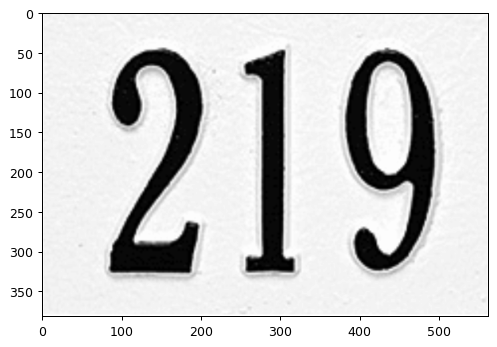

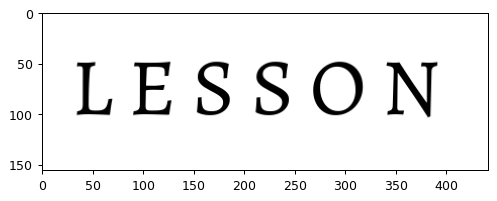

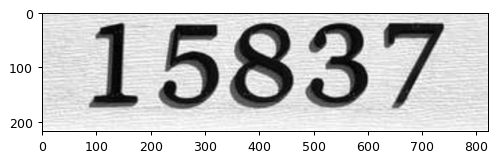

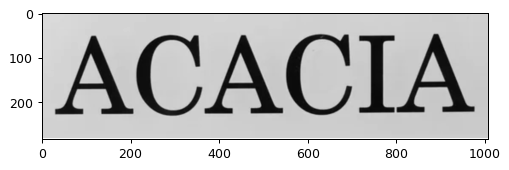

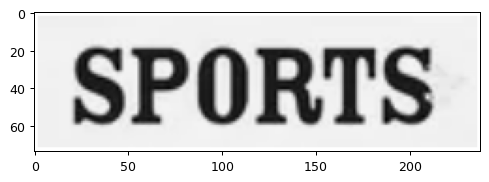

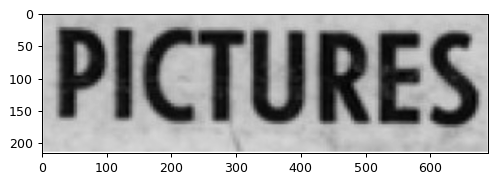

In [569]:
text_images = get_images()

Predict text

In [570]:
def ocr(image):
    text_lines = text_line_cut(image)
    for lines in text_lines:
        for i in range(len(text_lines)):
            letters = letter_cut(text_lines[i])
            texts = ''
            for i in range(len(letters)):
                img = letters[i]
                img = pad_image(letters[i], (255, 255))
                # img = invert_image(img)
                img = cv2.resize(img, (32,38))
                img = np.array(img)
                img = np.expand_dims(img, axis=0)
                img = np.expand_dims(img, axis=3)
                character_prediction = saved_model.predict(img, verbose = 0)
                label = np.argmax(character_prediction)
                text = label_names[label]
                texts = texts + text
        print("Prediction:", texts)
        plt.figure(dpi=80)
        plt.imshow(lines, cmap='gray')
        plt.show()


Prediction: 219


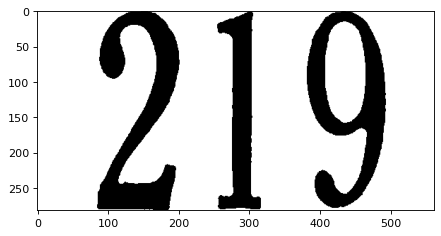

Prediction: LESSON


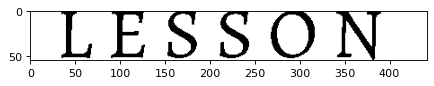

Prediction: 15837


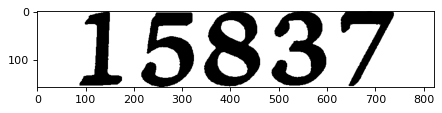

Prediction: ACACIA


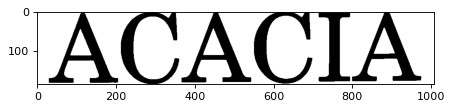

Prediction: SP0RTS


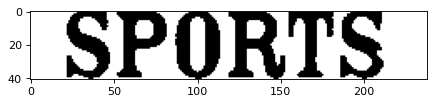

Prediction: PICTURES


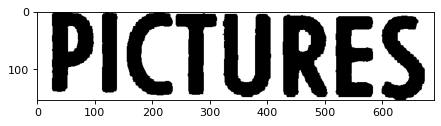

In [571]:
# Predict text
for image in text_images:
    ocr(image)